In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

import os
import glob
import zipfile
from time import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# 1. UNZIP AND LOAD FILE PATHS
# 1. UNZIP AND LOAD FILE PATHS
images_path = "/content/drive/MyDrive/Original Images"
masks_path  = "/content/drive/MyDrive/Original Masks"

image_files = sorted(glob.glob(os.path.join(images_path, "*.tif")))
mask_files  = sorted(glob.glob(os.path.join(masks_path, "*.tif")))

print(f"Found {len(image_files)} images and {len(mask_files)} masks")

image_files = sorted(glob.glob(os.path.join(images_path, "*.tif")))
mask_files  = sorted(glob.glob(os.path.join(masks_path, "*.tif")))

print(f"Found {len(image_files)} images and {len(mask_files)} masks")

Found 22 images and 22 masks
Found 22 images and 22 masks


Visualizing samples from the Dataset (after transforms)...


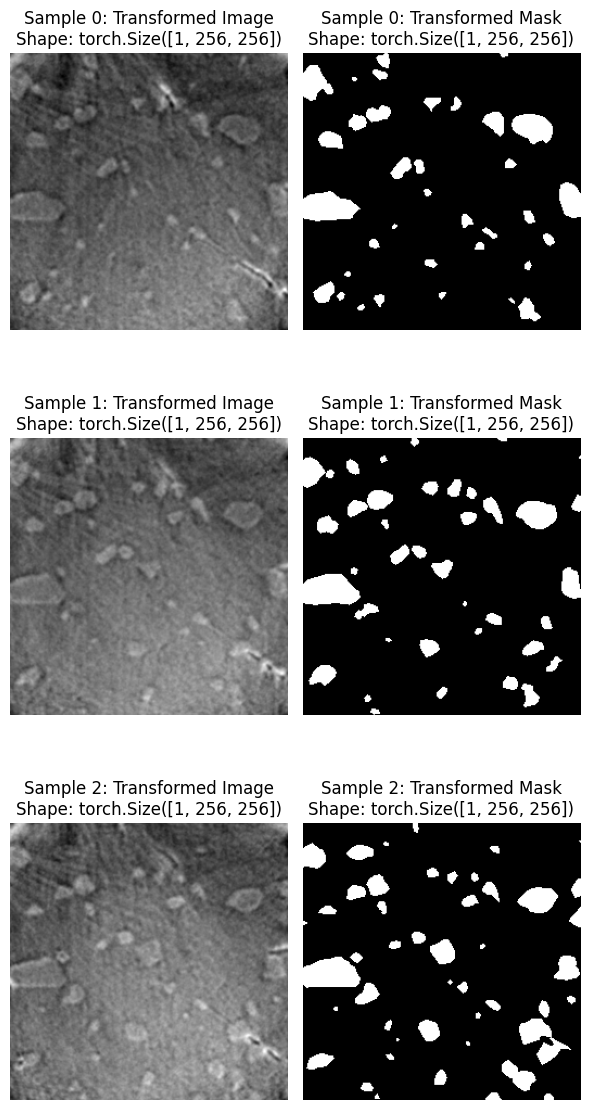


--- Analyzing Pixel Counts for a Single Mask (Sample 0) ---
Analyzing Sample 0 (after transforms):
Total Pixels: 65536
Pore (1.0) Pixels:   6211 (9.48%)
Background (0.0) Pixels: 59325 (90.52%)


In [ ]:
# 2. DATASET CLASS AND TRANSFORMS

class SegmentationDataset(Dataset):
    def __init__(self, image_files, mask_files, transform=None, mask_transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform
        self.mask_transform = mask_transform
        assert len(self.image_files) == len(self.mask_files), "Mismatch between images and masks"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        # --- THIS IS THE FIX ---
        # Load BOTH as-is (float images), do NOT use .convert()
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        # --- END FIX ---

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

import numpy as np

# 1. NEW IMAGE TRANSFORM

# This transform will resize, then perform min-max normalization
# to stretch the contrast, just like your example code.

def normalize_image_transform(img):
    """Normalizes a float PIL image to a [0, 1] tensor."""
    # Convert PIL image to numpy array
    np_img = np.array(img, dtype=np.float32)

    # Get min/max for normalization
    min_val = np.min(np_img)
    max_val = np.max(np_img)

    # Perform min-max normalization (contrast stretching)
    # Add 1e-6 to prevent division by zero if image is all one color
    if max_val - min_val > 1e-6:
        normalized_img = (np_img - min_val) / (max_val - min_val)
    else:
        # If image is solid, just set to 0
        normalized_img = np.zeros(np_img.shape, dtype=np.float32)

    # Add channel dimension and return as float tensor
    return torch.from_numpy(normalized_img).unsqueeze(0)


image_transform = transforms.Compose([
    # Use BILINEAR for resizing real images (looks better)
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(normalize_image_transform)
])

# 2. MASK TRANSFORM (Stays the same as before)

# This transform resizes, then converts the float data to a binary
# 0/1 mask based on a threshold (pixel > 0)

mask_transform = transforms.Compose([
    # Use NEAREST for resizing masks (preserves labels)
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Lambda(lambda img: torch.from_numpy(np.array(img) <= 0).unsqueeze(0).float())
])

# 1. Create a temporary dataset instance to test the transforms
print("Visualizing samples from the Dataset (after transforms)...")
viz_dataset = SegmentationDataset(
    image_files=image_files,
    mask_files=mask_files,
    transform=image_transform,
    mask_transform=mask_transform
)

# 2. Plot the first 3 samples
n_samples_to_plot = 3
plt.figure(figsize=(6, n_samples_to_plot * 4))

for i in range(n_samples_to_plot):
    # Get the transformed image and mask tensors
    image_tensor, mask_tensor = viz_dataset[i]

    # Squeeze() removes the channel dimension [1, 256, 256] -> [256, 256]
    # .numpy() converts the tensor for plotting

    # a) Transformed Image
    plt.subplot(n_samples_to_plot, 2, i*2 + 1)
    plt.imshow(image_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Sample {i}: Transformed Image\nShape: {image_tensor.shape}")
    plt.axis('off')

    # b) Transformed (Thresholded) Mask
    plt.subplot(n_samples_to_plot, 2, i*2 + 2)
    plt.imshow(mask_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Sample {i}: Transformed Mask\nShape: {mask_tensor.shape}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# --- ADDED: Pixel Count for a Single Mask ---
print("\n--- Analyzing Pixel Counts for a Single Mask (Sample 0) ---")

# 1. Get a single sample (the first one) from the dataset
# This applies the mask_transform, so the mask is already 0s and 1s
image_tensor, mask_tensor = viz_dataset[0]

# 2. Count the pixels
#    .sum() adds up all the 1.0s
pore_pixels = mask_tensor.sum().item()

#    .numel() gets the total number of elements
total_pixels = mask_tensor.numel()

#    The rest must be 0.0s
background_pixels = total_pixels - pore_pixels

# 3. Print the results
pore_percentage = (pore_pixels / total_pixels) * 100
bg_percentage = (background_pixels / total_pixels) * 100

print(f"Analyzing Sample 0 (after transforms):")
print(f"Total Pixels: {int(total_pixels)}")
print(f"Pore (1.0) Pixels:   {int(pore_pixels)} ({pore_percentage:.2f}%)")
print(f"Background (0.0) Pixels: {int(background_pixels)} ({bg_percentage:.2f}%)")

In [ ]:
# 3. DATASET SPLITTING AND DATALOADERS
full_dataset = SegmentationDataset(
    image_files=image_files,
    mask_files=mask_files,
    transform=image_transform,
    mask_transform=mask_transform
)

# Split
torch.manual_seed(42) # for reproducible splits
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nDataLoaders created.")

Total samples: 22
Training samples: 17
Validation samples: 2
Test samples: 3

DataLoaders created.


In [ ]:
# 5. LOSS FUNCTIONS

class BCELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        loss = torch.mean(y_pred - y_true*y_pred + torch.log(1 + torch.exp(-y_pred)))
        return loss

class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        y_true = y_true.float()
        p = torch.sigmoid(y_pred)
        if p.dim() == 3:
            p = p.unsqueeze(1)
            y_true = y_true.unsqueeze(1)
        elif y_true.dim() == 3:
            y_true = y_true.unsqueeze(1)
        N = p.shape[0]
        p_f = p.contiguous().view(N, -1)
        y_f = y_true.contiguous().view(N, -1)
        smooth = 1.0
        intersection = (p_f * y_f).sum(dim=1)
        denom = p_f.sum(dim=1) + y_f.sum(dim=1)
        dice = (2.0 * intersection + smooth) / (denom + smooth)
        return (1.0 - dice).mean()

class FocalLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        y_true = y_true.float()
        bce = nn.functional.binary_cross_entropy_with_logits(y_pred, y_true, reduction="none")
        p = torch.sigmoid(y_pred)
        pt = p * y_true + (1 - p) * (1 - y_true)
        gamma = 2.0
        focal = torch.pow((1 - pt).clamp(min=1e-6), gamma)
        loss = focal * bce
        return loss.mean()

class BCELoss_TotalVariation(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        loss = torch.mean(y_pred - y_true*y_pred + torch.log(1 + torch.exp(-y_pred)))
        x = torch.sigmoid(y_pred)
        if x.dim() == 3:
            x = x.unsqueeze(1)
        dh = x[:, :, 1:, :] - x[:, :, :-1, :]
        dw = x[:, :, :, 1:] - x[:, :, :, :-1]
        regularization = dh.abs().mean() + dw.abs().mean()
        return loss + 0.1*regularization


Starting evaluation on the test set...
Test Set Results (Averaged over 1 batches)
Pixel Accuracy (Rand): 93.47%
Dice Coefficient:      0.7286
Jaccard Index (IoU):   0.5731
Precision:             0.6479
Recall (Sensitivity):  0.8324

 Test Set Pixel Distribution (Ground Truth)
Total Pixels (all test masks): 196608
Total Pore (Foreground) Pixels: 20698 (10.53%)
Total Background Pixels:        175910 (89.47%)

Visualizing some test predictions...


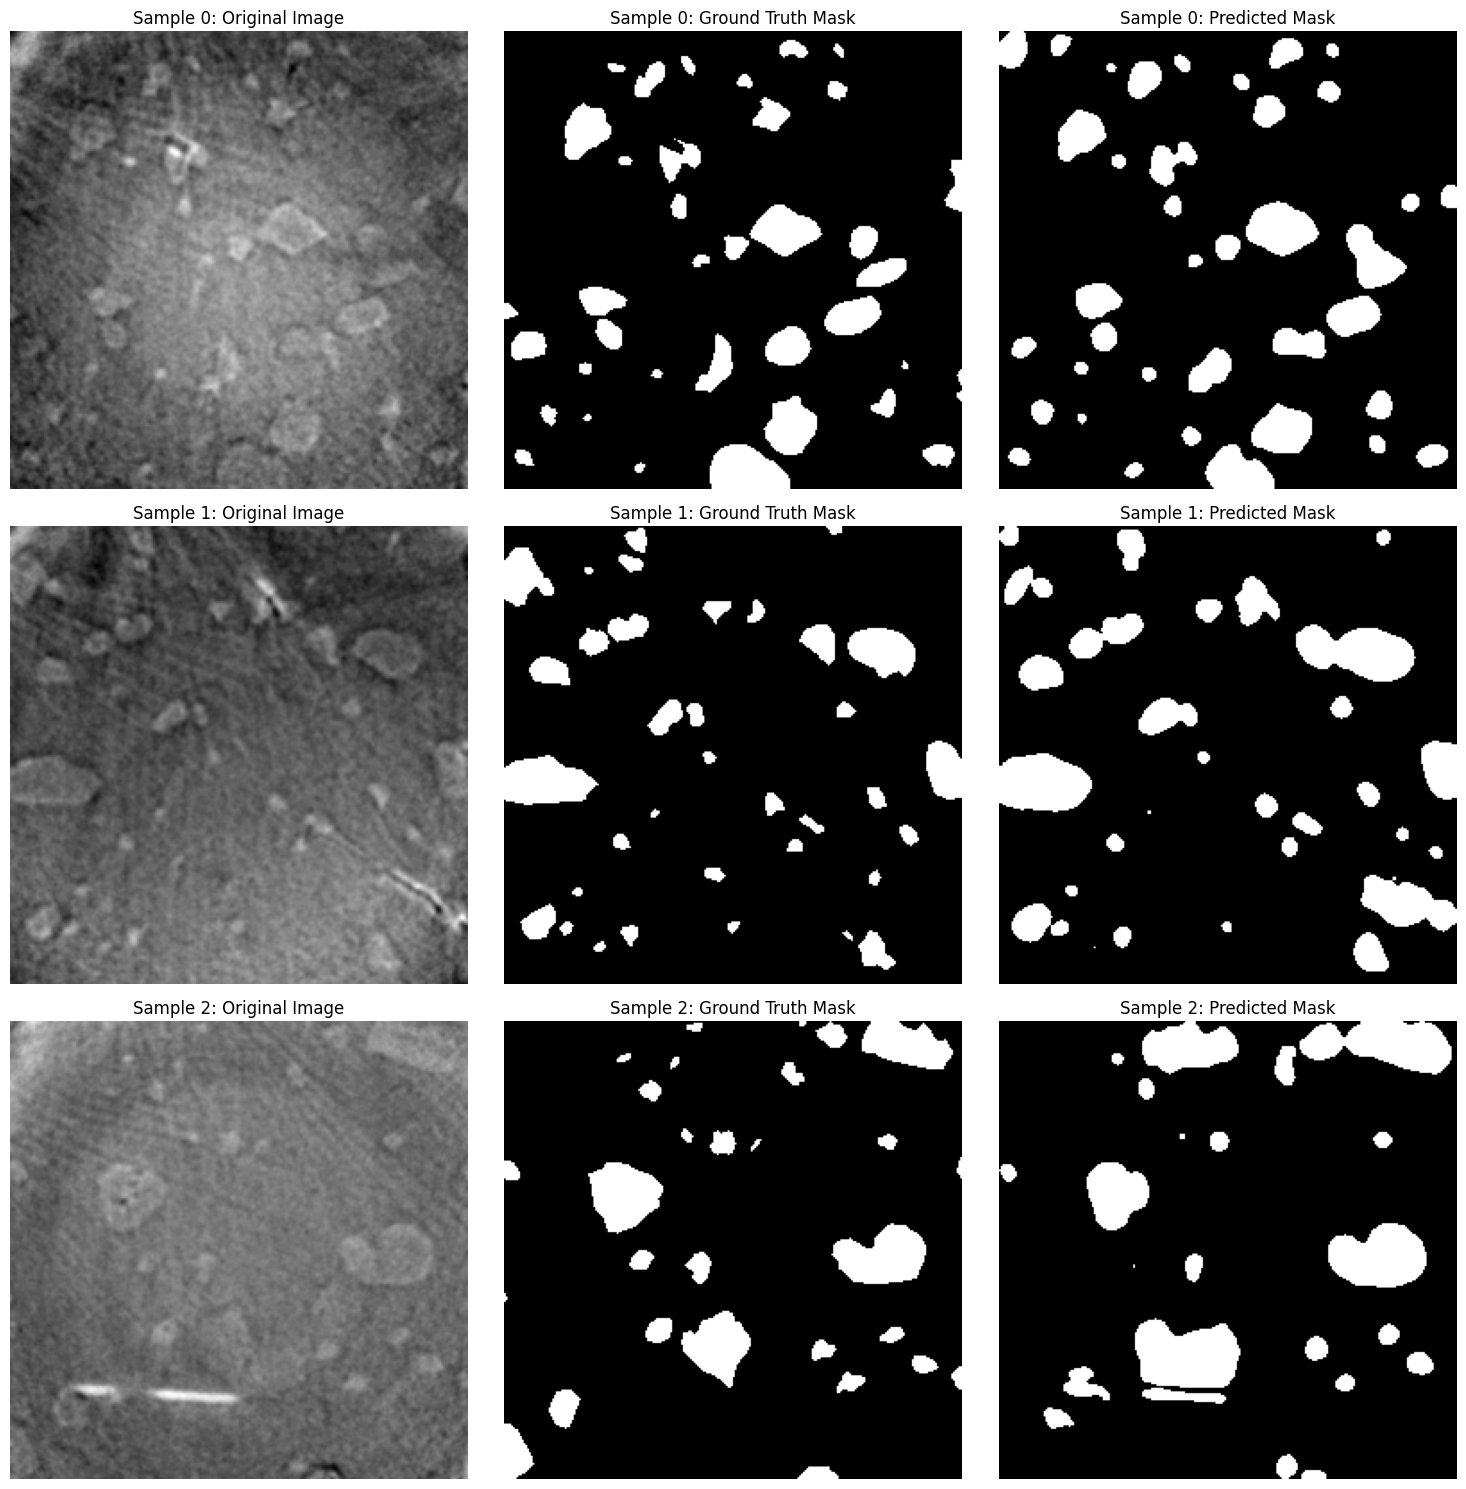

In [ ]:
# 1. SETUP FOR EVALUATION
model.eval()

# 2. METRIC FUNCTION
def calculate_all_metrics_batch(preds, y_true, smooth=1e-6):
    """
    Calculates all 5 metrics for a batch.
    Metrics are computed pixel-wise for the entire batch.
    """
    # Flatten tensors
    preds_f = preds.contiguous().view(-1).float()
    y_f = y_true.contiguous().view(-1).float()

    # Core Components
    tp = (preds_f * y_f).sum()
    fp = (preds_f * (1 - y_f)).sum()
    fn = ((1 - preds_f) * y_f).sum()
    tn = ((1 - preds_f) * (1 - y_f)).sum()
    total_pixels = y_f.numel()

    # Calculate Metrics
    precision = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)
    accuracy = (tp + tn) / total_pixels
    dice = (2.0 * tp + smooth) / (tp + fp + tp + fn + smooth)
    jaccard = (tp + smooth) / (tp + fp + fn + smooth)

    return precision.item(), recall.item(), accuracy.item(), dice.item(), jaccard.item()


# 3. TEST SET EVALUATION LOOP
print("\nStarting evaluation on the test set...")

# Initialize accumulators for all metrics
total_precision = 0
total_recall = 0
total_accuracy = 0
total_dice = 0
total_jaccard = 0
total_pore_pixels = 0
total_bg_pixels = 0

# Disable gradient calculations
with torch.no_grad():
    for X_batch, y_true in test_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        # 1. Forward pass (get logits)
        y_pred_logits = model(X_batch)

        # 2. Convert logits to binary predictions
        y_pred_probs = torch.sigmoid(y_pred_logits)
        y_pred_binary = (y_pred_probs > 0.5).float() # Threshold at 0.5

        # 3. Calculate all metrics for this batch and add to totals
        p, r, acc, d, j = calculate_all_metrics_batch(y_pred_binary, y_true)

        total_precision += p
        total_recall    += r
        total_accuracy  += acc
        total_dice      += d
        total_jaccard   += j


        # 4. Calculate pixel counts from the ground truth masks
        batch_pores = y_true.sum().item()
        batch_total = y_true.numel()
        batch_bg = batch_total - batch_pores

        total_pore_pixels += batch_pores
        total_bg_pixels += batch_bg

# CALCULATE AND PRINT FINAL METRICS
num_batches = len(test_loader)
avg_precision = total_precision / num_batches
avg_recall    = total_recall / num_batches
avg_accuracy  = total_accuracy / num_batches
avg_dice      = total_dice / num_batches
avg_jaccard   = total_jaccard / num_batches

print(f"Test Set Results (Averaged over {num_batches} batches)")
print(f"Pixel Accuracy (Rand): {avg_accuracy * 100:.2f}%")
print(f"Dice Coefficient:      {avg_dice:.4f}")
print(f"Jaccard Index (IoU):   {avg_jaccard:.4f}")
print(f"Precision:             {avg_precision:.4f}")
print(f"Recall (Sensitivity):  {avg_recall:.4f}")

print("\n Test Set Pixel Distribution (Ground Truth)")
total_pixels_all = total_pore_pixels + total_bg_pixels
pore_percentage = (total_pore_pixels / total_pixels_all) * 100
bg_percentage = (total_bg_pixels / total_pixels_all) * 100

print(f"Total Pixels (all test masks): {int(total_pixels_all)}")
print(f"Total Pore (Foreground) Pixels: {int(total_pore_pixels)} ({pore_percentage:.2f}%)")
print(f"Total Background Pixels:        {int(total_bg_pixels)} ({bg_percentage:.2f}%)")


# VISUALIZE A FEW PREDICTIONS
print("\nVisualizing some test predictions...")

# Get one batch from the test loader
X_test_viz, y_test_viz = next(iter(test_loader))
X_test_viz = X_test_viz.to(device)

model.eval()
with torch.no_grad():
    y_pred_logits_viz = model(X_test_viz)
    y_pred_probs_viz = torch.sigmoid(y_pred_logits_viz)
    y_pred_binary_viz = (y_pred_probs_viz > 0.5).float()

# Move data to CPU for plotting with numpy/matplotlib
X_test_cpu = X_test_viz.cpu()
y_test_cpu = y_test_viz.cpu()
y_pred_cpu = y_pred_binary_viz.cpu()

# Plot the first N samples (e.g., 3)
n_samples_to_plot = min(3, len(X_test_cpu)) # Ensure we don't exceed batch size

plt.figure(figsize=(15, n_samples_to_plot * 5))
for i in range(n_samples_to_plot):

    # a) Original Image (1-channel)
    plt.subplot(n_samples_to_plot, 3, i*3 + 1)
    plt.imshow(X_test_cpu[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i}: Original Image")
    plt.axis('off')

    # b) Ground Truth Mask
    plt.subplot(n_samples_to_plot, 3, i*3 + 2)
    plt.imshow(y_test_cpu[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i}: Ground Truth Mask")
    plt.axis('off')

    # c) Predicted Mask
    plt.subplot(n_samples_to_plot, 3, i*3 + 3)
    plt.imshow(y_pred_cpu[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i}: Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# === CARGAR MODELO PARA PSEUDOLABELING ===

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

pseudo_model = UNet(in_channels=1, out_channels=1).to(device)

model_path = "/content/drive/MyDrive/unet_pores.pth"
pseudo_model.load_state_dict(torch.load(model_path, map_location=device))
pseudo_model.eval()
print(f"Pesos cargados desde {model_path}")

# === TRANSFORM PARA INFERENCIA (SIN DATA AUG) ===

def normalize_image_transform_infer(img):
    np_img = np.array(img, dtype=np.float32)
    min_val = np.min(np_img)
    max_val = np.max(np_img)

    if max_val - min_val > 1e-6:
        normalized_img = (np_img - min_val) / (max_val - min_val)
    else:
        normalized_img = np.zeros(np_img.shape, dtype=np.float32)

    return torch.from_numpy(normalized_img).unsqueeze(0)

image_transform_infer = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(normalize_image_transform_infer)
])


Usando dispositivo: cuda
Pesos cargados desde results/unet_pores.pth


In [ ]:
# === DEFINIR RUTA DE IMÁGENES SIN MÁSCARA ===
# ⚠️ CAMBIA ESTA RUTA A TU CARPETA DE UNLABELED
unlabeled_images_path =  "/content/drive/MyDrive/unlabeled_images"  # <--- AJUSTA ESTO

unlabeled_image_files = sorted(glob.glob(os.path.join(unlabeled_images_path, "*.tif")))
print(f"Encontradas {len(unlabeled_image_files)} imágenes sin máscara")

class UnlabeledDataset(Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path)

        if self.transform:
            image_t = self.transform(image)
        else:
            image_t = torch.from_numpy(np.array(image, dtype=np.float32)).unsqueeze(0)

        return image_t, img_path

unlabeled_dataset = UnlabeledDataset(unlabeled_image_files, transform=image_transform_infer)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=4, shuffle=False)

print("Dataloader de unlabelled creado.")


Encontradas 120 imágenes sin máscara
Dataloader de unlabelled creado.


In [ ]:
# === DEFINIR RUTA DE IMÁGENES SIN MÁSCARA ===
# ⚠️ CAMBIA ESTA RUTA A TU CARPETA DE UNLABELED
unlabeled_images_path =  "/content/drive/MyDrive/unlabeled_images"  # <--- AJUSTA ESTO

unlabeled_image_files = sorted(glob.glob(os.path.join(unlabeled_images_path, "*.tif")))
print(f"Encontradas {len(unlabeled_image_files)} imágenes sin máscara")

class UnlabeledDataset(Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path)

        if self.transform:
            image_t = self.transform(image)
        else:
            image_t = torch.from_numpy(np.array(image, dtype=np.float32)).unsqueeze(0)

        return image_t, img_path

unlabeled_dataset = UnlabeledDataset(unlabeled_image_files, transform=image_transform_infer)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=4, shuffle=False)

print("Dataloader de unlabelled creado.")


Encontradas 120 imágenes sin máscara
Dataloader de unlabelled creado.


In [ ]:
# === GENERAR PSEUDOMÁSCARAS CON FILTRO DE CALIDAD ===

threshold = 0.95          # prob mínima por píxel
min_positive_pixels = 200 # al menos 200 píxeles de poros
max_pore_fraction   = 0.20  # como mucho el 20% de la imagen sean poros

pseudo_model.eval()

with torch.no_grad():
    for images_batch, paths in unlabeled_loader:
        images_batch = images_batch.to(device)

        logits = pseudo_model(images_batch)
        probs  = torch.sigmoid(logits)
        preds  = (probs > threshold).float().cpu()

        for i in range(preds.shape[0]):
            mask_tensor = preds[i, 0]   # [256,256]
            positive_pixels = mask_tensor.sum().item()
            total_pixels    = mask_tensor.numel()
            pore_fraction   = positive_pixels / total_pixels

            img_name = os.path.basename(paths[i])
            print(f"{img_name}: {positive_pixels} px pos ({pore_fraction*100:.3f}%)")

            # 🔴 FILTRO 1: muy pocos poros → probablemente ruido
            if positive_pixels < min_positive_pixels:
                print("   -> DESCARTADA: muy pocos poros")
                continue

            # 🔴 FILTRO 2: demasiados poros → probablemente máscara mala
            if pore_fraction > max_pore_fraction:
                print("   -> DESCARTADA: ocupa demasiada área")
                continue

            # ✅ Si pasa los filtros, la guardamos
            mask_np  = (mask_tensor.numpy() * 255).astype(np.uint8)
            mask_img = Image.fromarray(mask_np, mode="L")
            save_path = os.path.join(pseudo_masks_dir, img_name)
            mask_img.save(save_path)
            print(f"   -> GUARDADA en {save_path}")


In [ ]:
# === CONSTRUIR DATASET COMBINADO (GT + PSEUDOLABELS) ===

# 1. Cargamos las pseudomáscaras que existen
pseudo_mask_files = sorted(glob.glob(os.path.join(pseudo_masks_dir, "*.tif")))
print(f"Pseudomáscaras encontradas: {len(pseudo_mask_files)}")

# Mapeo nombre -> ruta de máscara
pseudo_mask_by_name = {os.path.basename(p): p for p in pseudo_mask_files}

# 2. Emparejamos imágenes unlabelled con sus pseudomáscaras
pseudo_image_files = []
pseudo_gt_files = []

for img_path in unlabeled_image_files:
    name = os.path.basename(img_path)
    if name in pseudo_mask_by_name:
        pseudo_image_files.append(img_path)
        pseudo_gt_files.append(pseudo_mask_by_name[name])

print(f"Parejas imagen+pseudomáscara válidas: {len(pseudo_image_files)}")

# 3. Combinamos:
#    - imágenes originales + GT
#    - imágenes unlabelled + pseudomáscaras
all_image_files = image_files + pseudo_image_files
all_mask_files  = mask_files  + pseudo_gt_files

print(f"Total imágenes tras añadir pseudolabels: {len(all_image_files)}")
print(f"Total máscaras  tras añadir pseudolabels: {len(all_mask_files)}")

# 4. Nuevo dataset completo con data augmentation de entrenamiento
full_dataset_pseudo = SegmentationDataset(
    image_files=all_image_files,
    mask_files=all_mask_files,
    transform=image_transform,       # el mismo que usabas para train
    mask_transform=mask_transform
)

# 5. Nuevo split train/val/test
torch.manual_seed(42)
total_size = len(full_dataset_pseudo)
train_size = int(0.8 * total_size)
val_size   = int(0.1 * total_size)
test_size  = total_size - train_size - val_size

print(f"Total samples (GT + pseudo): {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

train_dataset_pseudo, val_dataset_pseudo, test_dataset_pseudo = random_split(
    full_dataset_pseudo, [train_size, val_size, test_size]
)

batch_size = 8
train_loader_pseudo = DataLoader(train_dataset_pseudo, batch_size=batch_size, shuffle=True)
val_loader_pseudo   = DataLoader(val_dataset_pseudo,   batch_size=batch_size, shuffle=False)
test_loader_pseudo  = DataLoader(test_dataset_pseudo,  batch_size=batch_size, shuffle=False)

print("Dataloaders con pseudolabels creados.")


NameError: name 'glob' is not defined

In [ ]:
# === MÉTRICAS NECESARIAS PARA EL FINE-TUNING ===

def dice_overlap(y_real, y_pred):
    intersection = torch.sum(torch.mul(y_real, y_pred))
    denominator = torch.sum(y_real) + torch.sum(y_pred)
    return (2 * intersection) / (denominator + 1e-8)

def intersection_over_union(y_real, y_pred):
    intersection = torch.sum(torch.mul(y_real, y_pred))
    union = torch.sum(y_real) + torch.sum(y_pred) - intersection
    return intersection / (union + 1e-8)

def accuracy(y_real, y_pred):
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)
    correct_predictions = torch.sum(y_real == y_pred)
    total_pixels = y_real.size(0)
    return correct_predictions.float() / total_pixels

def sensitivity(y_real, y_pred):
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)
    tp = torch.sum((y_real == 1) & (y_pred == 1))
    fn = torch.sum((y_real == 1) & (y_pred == 0))
    return tp / (tp + fn + 1e-8)

def specificity(y_real, y_pred):
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)
    tn = torch.sum((y_real == 0) & (y_pred == 0))
    fp = torch.sum((y_real == 0) & (y_pred == 1))
    return tn / (tn + fp + 1e-8)


In [ ]:
# === REENTRENAR LA UNET CON GT + PSEUDOLABELS ===

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Cargamos el modelo con los pesos previos (entrenado solo en GT)
model_pseudo = UNet(in_channels=1, out_channels=1).to(device)
model_pseudo.load_state_dict(torch.load("results/unet_pores.pth", map_location=device))
print("Pesos iniciales cargados desde results/unet_pores.pth")

# Optimizador con LR un poco más pequeño para fine-tuning
learning_rate = 1e-4
opt_pseudo = optim.Adam(model_pseudo.parameters(), lr=learning_rate)

# Usamos la misma loss (DiceLoss por ejemplo)
loss_fn_pseudo = DiceLoss()
print(f"Using loss function: {loss_fn_pseudo.__class__.__name__}")

epochs_finetune = 15   # finetune cortito, no hace falta 100
train_losses_pseudo = []
val_losses_pseudo   = []

print("\nStarting fine-tuning with pseudolabels...")

for epoch in range(epochs_finetune):
    tic = time()

    # ---- TRAIN ----
    model_pseudo.train()
    avg_loss = 0
    avg_acc  = 0

    for X_batch, y_true in train_loader_pseudo:
        X_batch = X_batch.to(device)
        y_true  = y_true.to(device)

        opt_pseudo.zero_grad()

        y_pred_logits = model_pseudo(X_batch)
        loss = loss_fn_pseudo(y_pred_logits, y_true)
        loss.backward()
        opt_pseudo.step()

        avg_loss += loss.item() / len(train_loader_pseudo)

        y_pred = torch.sigmoid(y_pred_logits)
        y_pred_bin = (y_pred > 0.5).float()
        avg_acc += accuracy(y_true, y_pred_bin).item() / len(train_loader_pseudo)

    # ---- VAL ----
    model_pseudo.eval()
    avg_val_loss = 0
    avg_dice = 0
    avg_iou  = 0

    with torch.no_grad():
        for X_batch, y_true in val_loader_pseudo:
            X_batch = X_batch.to(device)
            y_true  = y_true.to(device)

            y_pred_logits = model_pseudo(X_batch)
            val_loss = loss_fn_pseudo(y_pred_logits, y_true)
            avg_val_loss += val_loss.item() / len(val_loader_pseudo)

            y_pred = torch.sigmoid(y_pred_logits)
            y_pred_bin = (y_pred > 0.5).float()

            avg_dice += dice_overlap(y_true, y_pred_bin).item() / len(val_loader_pseudo)
            avg_iou  += intersection_over_union(y_true, y_pred_bin).item() / len(val_loader_pseudo)

    toc = time()

    print(f'* Epoch {epoch+1:02d}/{epochs_finetune} (Time: {toc-tic:.2f}s)')
    print(f'  - Train Loss: {avg_loss:.4f}')
    print(f'  - Train Acc : {avg_acc:.4f}')
    print(f'  - Val Loss  : {avg_val_loss:.4f}')
    print(f'  - Val Dice  : {avg_dice:.4f}')
    print(f'  - Val IoU   : {avg_iou:.4f}\n')

    train_losses_pseudo.append(avg_loss)
    val_losses_pseudo.append(avg_val_loss)

# Guardar el modelo finetuneado
os.makedirs("results", exist_ok=True)
torch.save(model_pseudo.state_dict(), "results/unet_pores_pseudo_finetuned.pth")
print("Modelo finetuneado guardado en results/unet_pores_pseudo_finetuned.pth")


Usando dispositivo: cuda
Pesos iniciales cargados desde results/unet_pores.pth
Using loss function: DiceLoss

Starting fine-tuning with pseudolabels...
* Epoch 01/15 (Time: 10.82s)
  - Train Loss: 0.5396
  - Train Acc : 0.4442
  - Val Loss  : 0.4440
  - Val Dice  : 0.6650
  - Val IoU   : 0.4986

* Epoch 02/15 (Time: 10.85s)
  - Train Loss: 0.2560
  - Train Acc : 0.7665
  - Val Loss  : 0.3299
  - Val Dice  : 0.8418
  - Val IoU   : 0.7269

* Epoch 03/15 (Time: 10.42s)
  - Train Loss: 0.2035
  - Train Acc : 0.8201
  - Val Loss  : 0.1941
  - Val Dice  : 0.8864
  - Val IoU   : 0.7960

* Epoch 04/15 (Time: 10.30s)
  - Train Loss: 0.2110
  - Train Acc : 0.8369
  - Val Loss  : 0.1311
  - Val Dice  : 0.9341
  - Val IoU   : 0.8764

* Epoch 05/15 (Time: 9.93s)
  - Train Loss: 0.1540
  - Train Acc : 0.8920
  - Val Loss  : 0.1178
  - Val Dice  : 0.9442
  - Val IoU   : 0.8943

* Epoch 06/15 (Time: 10.20s)
  - Train Loss: 0.1434
  - Train Acc : 0.8992
  - Val Loss  : 0.1177
  - Val Dice  : 0.9468
  -

In [ ]:
# === FUNCIÓN DE EVALUACIÓN EN UN TEST LOADER ===

def evaluate_model(model, test_loader, device, name="Model"):
    model.eval()

    total_dice = 0.0
    total_iou  = 0.0
    total_acc  = 0.0
    total_sens = 0.0
    total_spec = 0.0

    num_batches = len(test_loader)

    with torch.no_grad():
        for X_batch, y_true in test_loader:
            X_batch = X_batch.to(device)
            y_true  = y_true.to(device)

            # Forward
            y_pred_logits = model(X_batch)
            y_pred = torch.sigmoid(y_pred_logits)
            y_pred_bin = (y_pred > 0.5).float()

            # Métricas por batch
            total_dice += dice_overlap(y_true, y_pred_bin).item()
            total_iou  += intersection_over_union(y_true, y_pred_bin).item()
            total_acc  += accuracy(y_true, y_pred_bin).item()
            total_sens += sensitivity(y_true, y_pred_bin).item()
            total_spec += specificity(y_true, y_pred_bin).item()

    # Promedios
    avg_dice = total_dice / num_batches
    avg_iou  = total_iou  / num_batches
    avg_acc  = total_acc  / num_batches
    avg_sens = total_sens / num_batches
    avg_spec = total_spec / num_batches

    print(f"\n===== RESULTADOS TEST: {name} =====")
    print(f"Dice Coefficient:     {avg_dice:.4f}")
    print(f"IoU (Jaccard):        {avg_iou:.4f}")
    print(f"Accuracy:             {avg_acc:.4f}")
    print(f"Sensitivity (Recall): {avg_sens:.4f}")
    print(f"Specificity:          {avg_spec:.4f}")
    print("====================================\n")

    return {
        "dice": avg_dice,
        "iou": avg_iou,
        "accuracy": avg_acc,
        "sensitivity": avg_sens,
        "specificity": avg_spec
    }


In [ ]:
# === COMPARAR MODELO BASE vs MODELO + PSEUDOLABELS EN EL MISMO VAL SET (ORIGINAL) ===

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# 1) Modelo base (solo GT)
base_model = UNet(in_channels=1, out_channels=1).to(device)
base_model.load_state_dict(torch.load("results/unet_pores.pth", map_location=device))

metrics_base = evaluate_model(
    base_model,
    val_loader,   # <<< VALIDATION SET ORIGINAL, CON GT CORRECTAS
    device,
    name="UNet base (solo GT)"
)

# 2) Modelo fine-tuned con pseudolabels
finetuned_model = UNet(in_channels=1, out_channels=1).to(device)
finetuned_model.load_state_dict(torch.load("results/unet_pores_pseudo_finetuned.pth", map_location=device))

metrics_pseudo = evaluate_model(
    finetuned_model,
    val_loader,   # <<< MISMO VAL SET
    device,
    name="UNet + pseudolabels (fine-tuning)"
)

# 3) Comparación numérica
print("\n===== COMPARACIÓN FINAL EN VAL SET (GT REAL) =====")
for k in metrics_base.keys():
    mb = metrics_base[k]
    mp = metrics_pseudo[k]
    diff = mp - mb
    print(f"{k.upper():>12}: base = {mb:.4f} | pseudo = {mp:.4f} | Δ = {diff:+.4f}")
print("==================================================\n")


Usando dispositivo: cuda

===== RESULTADOS TEST: UNet base (solo GT) =====
Dice Coefficient:     0.7825
IoU (Jaccard):        0.6428
Accuracy:             0.9455
Sensitivity (Recall): 0.8678
Specificity:          0.9554


===== RESULTADOS TEST: UNet + pseudolabels (fine-tuning) =====
Dice Coefficient:     0.8378
IoU (Jaccard):        0.7209
Accuracy:             0.9613
Sensitivity (Recall): 0.8839
Specificity:          0.9712


===== COMPARACIÓN FINAL EN VAL SET (GT REAL) =====
        DICE: base = 0.7825 | pseudo = 0.8378 | Δ = +0.0553
         IOU: base = 0.6428 | pseudo = 0.7209 | Δ = +0.0781
    ACCURACY: base = 0.9455 | pseudo = 0.9613 | Δ = +0.0158
 SENSITIVITY: base = 0.8678 | pseudo = 0.8839 | Δ = +0.0161
 SPECIFICITY: base = 0.9554 | pseudo = 0.9712 | Δ = +0.0158



In [ ]:
# === EVALUAR MODELO BASE Y MODELO CON PSEUDOLABELS EN EL MISMO TEST SET ===

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# --- Modelo base (solo entrenado con GT) ---
base_model = UNet(in_channels=1, out_channels=1).to(device)
base_model.load_state_dict(torch.load("results/unet_pores.pth", map_location=device))

metrics_base = evaluate_model(
    base_model,
    test_loader_pseudo,        # test del dataset GT + pseudo
    device,
    name="UNet base (solo GT)"
)

# --- Modelo finetuneado con pseudolabels ---
finetuned_model = UNet(in_channels=1, out_channels=1).to(device)
finetuned_model.load_state_dict(torch.load("results/unet_pores_pseudo_finetuned.pth", map_location=device))

metrics_pseudo = evaluate_model(
    finetuned_model,
    test_loader_pseudo,
    device,
    name="UNet + pseudolabels (fine-tuning)"
)

# --- Comparación numérica lado a lado ---
print("\n===== COMPARACIÓN FINAL (mismo test set) =====")
for k in metrics_base.keys():
    mb = metrics_base[k]
    mp = metrics_pseudo[k]
    diff = mp - mb
    print(f"{k.upper():>12}: base = {mb:.4f} | pseudo = {mp:.4f} | Δ = {diff:+.4f}")
print("==============================================\n")


Usando dispositivo: cuda

===== RESULTADOS TEST: UNet base (solo GT) =====
Dice Coefficient:     0.0917
IoU (Jaccard):        0.0483
Accuracy:             0.1617
Sensitivity (Recall): 0.0569
Specificity:          0.3393


===== RESULTADOS TEST: UNet + pseudolabels (fine-tuning) =====
Dice Coefficient:     0.9720
IoU (Jaccard):        0.9456
Accuracy:             0.9596
Sensitivity (Recall): 0.9598
Specificity:          0.9524


===== COMPARACIÓN FINAL (mismo test set) =====
        DICE: base = 0.0917 | pseudo = 0.9720 | Δ = +0.8804
         IOU: base = 0.0483 | pseudo = 0.9456 | Δ = +0.8974
    ACCURACY: base = 0.1617 | pseudo = 0.9596 | Δ = +0.7979
 SENSITIVITY: base = 0.0569 | pseudo = 0.9598 | Δ = +0.9029
 SPECIFICITY: base = 0.3393 | pseudo = 0.9524 | Δ = +0.6130



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
files.download("results/unet_pores_pseudo_finetuned.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Usando dispositivo: cuda
Modelo UNet + pseudolabels cargado.


Starting evaluation on the test set...

===== Test Set Results (UNet + pseudolabeling) =====
Pixel Accuracy (Rand): 95.96%
Dice Coefficient:      0.9720
Jaccard Index (IoU):   0.9456
Precision:             0.9845
Recall (Sensitivity):  0.9598

Ground Truth Pixel Distribution:
Total Pixels (test masks): 983040
Pore Pixels:   738414 (75.12%)
Background:    244626 (24.88%)

Visualizing test predictions...


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

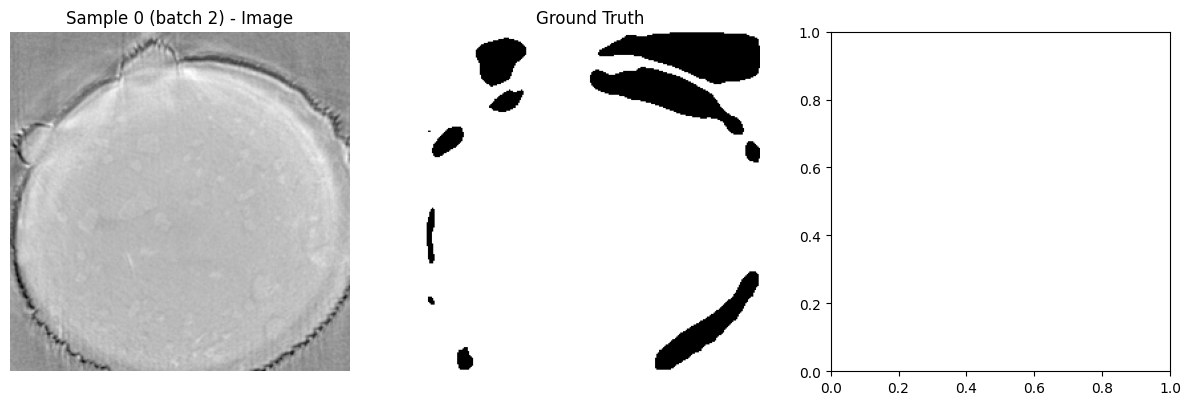

In [ ]:
# =====================================================
#     EVALUACIÓN COMPLETA: UNet + PSEUDOLABELING
# =====================================================

import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# 1. Cargar modelo finetuneado con pseudolabels
model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load("results/unet_pores_pseudo_finetuned.pth", map_location=device))
model.eval()
print("Modelo UNet + pseudolabels cargado.\n")

# 2. Métricas por batch
def calculate_all_metrics_batch(preds, y_true, smooth=1e-6):
    preds_f = preds.contiguous().view(-1).float()
    y_f = y_true.contiguous().view(-1).float()

    tp = (preds_f * y_f).sum()
    fp = (preds_f * (1 - y_f)).sum()
    fn = ((1 - preds_f) * y_f).sum()
    tn = ((1 - preds_f) * (1 - y_f)).sum()
    total_pixels = y_f.numel()

    precision = (tp + smooth) / (tp + fp + smooth)
    recall    = (tp + smooth) / (tp + fn + smooth)
    accuracy  = (tp + tn) / total_pixels
    dice      = (2 * tp + smooth) / (tp + fp + tp + fn + smooth)
    jaccard   = (tp + smooth) / (tp + fp + fn + smooth)

    return precision.item(), recall.item(), accuracy.item(), dice.item(), jaccard.item()

# 3. Evaluación en todo el test
print("\nStarting evaluation on the test set...")

total_precision = total_recall = total_accuracy = 0
total_dice = total_jaccard = 0
total_pore_pixels = total_bg_pixels = 0

with torch.no_grad():
    for X_batch, y_true in test_loader_pseudo:
        X_batch = X_batch.to(device)
        y_true  = y_true.to(device)

        logits = model(X_batch)
        probs  = torch.sigmoid(logits)
        preds  = (probs > 0.5).float()

        p, r, acc, d, j = calculate_all_metrics_batch(preds, y_true)
        total_precision += p
        total_recall    += r
        total_accuracy  += acc
        total_dice      += d
        total_jaccard   += j

        total_pore_pixels += y_true.sum().item()
        total_bg_pixels   += (y_true.numel() - y_true.sum().item())

num_batches   = len(test_loader_pseudo)
avg_precision = total_precision / num_batches
avg_recall    = total_recall    / num_batches
avg_accuracy  = total_accuracy  / num_batches
avg_dice      = total_dice      / num_batches
avg_jaccard   = total_jaccard   / num_batches

print(f"\n===== Test Set Results (UNet + pseudolabeling) =====")
print(f"Pixel Accuracy (Rand): {avg_accuracy * 100:.2f}%")
print(f"Dice Coefficient:      {avg_dice:.4f}")
print(f"Jaccard Index (IoU):   {avg_jaccard:.4f}")
print(f"Precision:             {avg_precision:.4f}")
print(f"Recall (Sensitivity):  {avg_recall:.4f}")

print("\nGround Truth Pixel Distribution:")
total_pixels_all = total_pore_pixels + total_bg_pixels
pore_percentage  = (total_pore_pixels / total_pixels_all) * 100
bg_percentage    = (total_bg_pixels   / total_pixels_all) * 100

print(f"Total Pixels (test masks): {int(total_pixels_all)}")
print(f"Pore Pixels:   {int(total_pore_pixels)} ({pore_percentage:.2f}%)")
print(f"Background:    {int(total_bg_pixels)} ({bg_percentage:.2f}%)")

# 4. Visualizar varias imágenes DISTINTAS del test

print("\nVisualizing test predictions...")

batch_idx = 2   # <<< CAMBIA ESTE NÚMERO PARA OTRO LOTE

with torch.no_grad():
    for b, (X_batch, y_batch) in enumerate(test_loader_pseudo):
        if b == batch_idx:
            X_test_viz = X_batch.to(device)
            y_test_viz = y_batch
            logits_viz = model(X_test_viz)
            probs_viz  = torch.sigmoid(logits_viz)
            preds_viz  = (probs_viz > 0.5).float().cpu()
            break

X_cpu = X_test_viz.cpu()
y_cpu = y_test_viz.cpu()
p_cpu = preds_viz

n_samples_to_plot = min(3, len(X_cpu))

plt.figure(figsize=(15, 5 * n_samples_to_plot))
for i in range(n_samples_to_plot):
    plt.subplot(n_samples_to_plot, 3, i*3 + 1)
    plt.imshow(X_cpu[i].squeeze(), cmap="gray")
    plt.title(f"Sample {i} (batch {batch_idx}) - Image")
    plt.axis("off")

    plt.subplot(n_samples_to_plot, 3, i*3 + 2)
    plt.imshow(y_cpu[i].squeeze(), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(n_samples_to_plot, 3, i*3 + 3)
    plt.imshow(p_cpu[i].squeeze(), cmap="gray")
    plt.title("Prediction (pseudo)")
    plt.axis("off")

plt.tight_layout()
plt.show()




Imagen: /content/drive/MyDrive/Original Images/image_v2_20.tif
Máscara real: /content/drive/MyDrive/Original Masks/image_v2_mask_20.tif


/tmp/ipython-input-4099294198.py:64: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4099294198.py:64: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4099294198.py:64: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


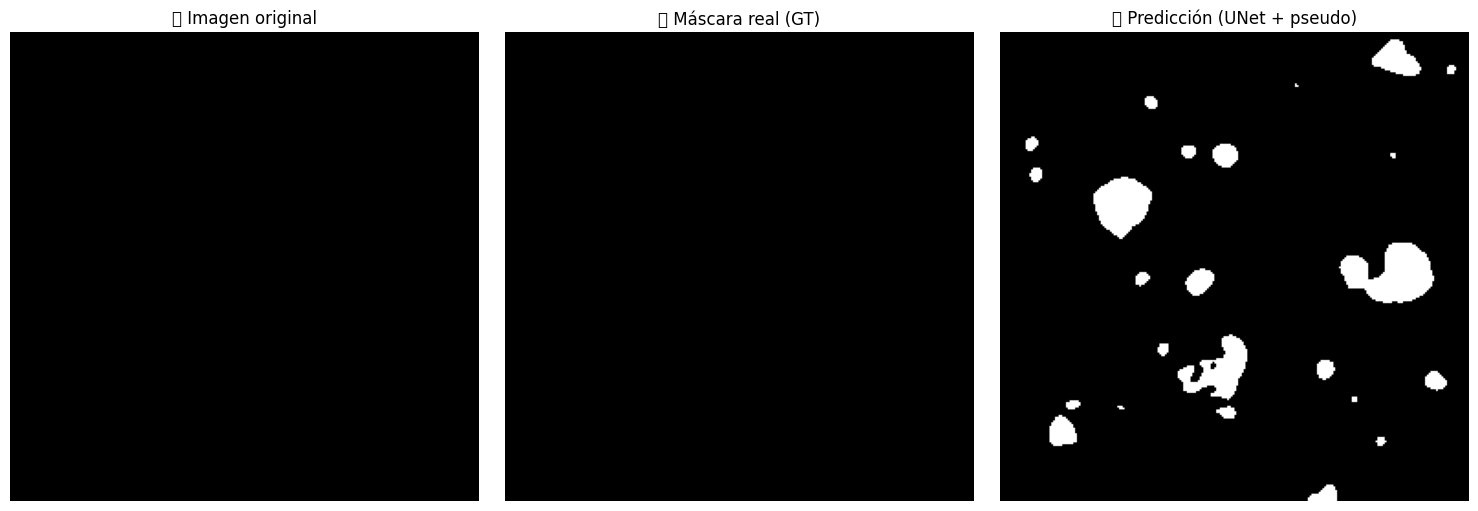

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch

# ============================
# 1) ESPECIFICA EL NOMBRE
# ============================
IMG_NAME = "image_v2_20.tif"   # <<< CAMBIA SOLO ESTO


# ============================
# 2) ENCONTRAR RUTAS
# ============================
img_path  = os.path.join(images_path, IMG_NAME)
mask_path = os.path.join(masks_path,  "image_v2_mask_20.tif")

print("Imagen:", img_path)
print("Máscara real:", mask_path)

# Cargar archivos
img = Image.open(img_path)
mask = Image.open(mask_path)

# ============================
# 3) Preprocesar imagen
# ============================
img_tensor = image_transform_infer(img).unsqueeze(0).to(device)


# ============================
# 4) Cargar modelo finetuneado
# ============================
model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load("results/unet_pores_pseudo_finetuned.pth", map_location=device))
model.eval()

with torch.no_grad():
    logits = model(img_tensor)
    probs = torch.sigmoid(logits)
    pred = (probs > 0.5).float().cpu().squeeze().numpy()


# ============================
# 5) Plotear las tres
# ============================
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("🖼️ Imagen original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.title("🎯 Máscara real (GT)")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(pred, cmap='gray')
plt.title("🤖 Predicción (UNet + pseudo)")
plt.axis('off')

plt.tight_layout()
plt.show()

